In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


images = []
label = []
import os
for dirname, _, filenames in os.walk('/content/gdrive/MyDrive/Kuliah/StudiIndenden/Dataset/batik_dataset2/'):
    for filename in filenames:
        images.append(os.path.join(dirname, filename).split('/')[-1])
        label.append(os.path.join(dirname, filename).split('/')[-2])


In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import time
from torch.nn import functional as F
from torchvision import models
import torch.nn as nn
import torch
import random
import PIL

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
labels = np.unique(label)
ints = np.arange(0, len(label))
dicts = dict(zip(labels, ints))
dicts

{'batik-bali': 0,
 'batik-cirebon': 1,
 'batik-pekalongan': 2,
 'batik-solo': 3,
 'batik-yogya': 4}

In [ ]:
PATH = "/content/gdrive/MyDrive/Kuliah/StudiIndenden/Dataset/batik_dataset2/"

df_full = pd.DataFrame({'image_id':images, 'label':label})

#FINDING BAD FILE

index = []
for i in range(len(df_full)):
    try:
        Image.open(PATH + str(df_full['label'].values[i]) + '/' + str(df_full['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

df = df_full.drop(index)
df.head()

image_id       label
0                                          y7989.jpg  batik-bali
1  bintang_mira_bintang_mira_kain_batik_bali_moti...  batik-bali
2                      Motif-Bali-Jagatan-Pisang.jpg  batik-bali
3  3c9fb5191d7e5fb1dd86d95b9e144e74.jpg_720x720q8...  batik-bali
4  indonesian-batik-bali-motif-style-600w-1422990...  batik-bali

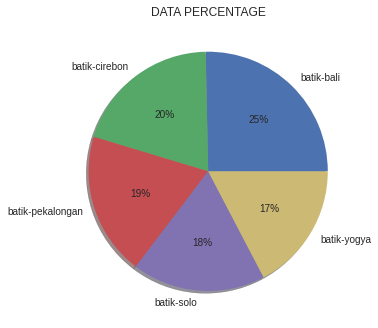

In [ ]:
target, count = np.unique(df['label'], return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = target,  autopct='%1.f%%', shadow=True)
plt.title('DATA PERCENTAGE')
plt.show()

In [ ]:
class Batik(Dataset):
    def __init__(self, x, y, path, map_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.map_label = map_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.map_label[self.y[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.X)
    
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df['image_id'].values, df['label'].values, 
    test_size=0.15, stratify=df['label'].values, 
    random_state=77)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, 
    stratify=y_trainval, test_size=0.15,
    random_state=77)


len(X_train), len(X_val), len(X_test)

(107, 20, 23)

In [ ]:
#DATALOADER
mean= [0.485, 0.456, 0.406] 
std= [0.229, 0.224, 0.225]
batch_size = 50

train_transform = T.Compose([T.Resize((450, 450)),
                             T.RandomHorizontalFlip(),
                             T.RandomVerticalFlip(),
                             T.RandomRotation(20),
                             T.ToTensor(),
                             T.Normalize(mean, std)
                            ])

val_transform = T.Compose([T.Resize((450, 450)),
                           T.ToTensor(),
                           T.Normalize(mean, std),
                          ])

train_set = Batik(X_train, y_train, PATH, transform=train_transform)
val_set = Batik(X_val, y_val, PATH, transform=val_transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, 
                                           num_workers=8, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, 
                                         num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batik-cirebon


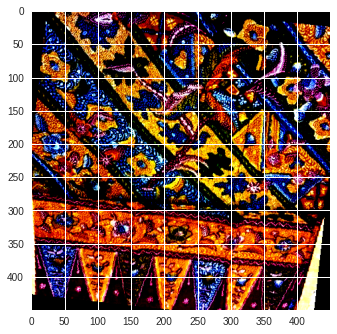

In [ ]:
#tampilkan batik random
int_label = dict(zip(ints, labels))


img, label = train_set[random.randint(0, len(X_train))]
plt.imshow(img.permute(1,2,0));
print(int_label[label])

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=20, bias=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

epoch = 400
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, epochs=epoch,
                                               steps_per_epoch=len(train_loader))

In [ ]:
train_losses = []
val_losses =[]
train_accuracy = []
val_acc = []
for e in range(epoch):
    model.to(device)
    model.train()
    
    train_loss = 0
    train_acc = 0
    since = time.time()
    for image, label in tqdm(train_loader, total=len(train_loader)):
        optimizer.zero_grad()
        
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        
        train_loss += loss
        train_acc += accuracy(output, label)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    else:
        with torch.no_grad():
            model.eval()
            
            running_loss = 0
            val_accuracy =0
            for image, label in val_loader:
                image = image.to(device)
                label = label.to(device)

                output = model(image)
                loss = criterion(output, label)
                val_accuracy += accuracy(output, label)
                running_loss += loss
                
    train_losses.append((train_loss/len(train_loader)).item())
    val_losses.append((running_loss/len(val_loader)).item())
    train_accuracy.append(train_acc/ len(train_loader))
    val_acc.append(val_accuracy/len(val_loader))
    
    print('epochs {}/{}..'.format(e+1, epoch),
          'train loss {:.3f}..'.format(train_loss/len(train_loader)),
          'val loss {:.3f}..'.format(running_loss/len(val_loader)),
          'train accuracy {:.3f}..'.format(train_acc/ len(train_loader)),
          'val accuracy {:.3f}..'.format(val_accuracy/len(val_loader)),
          'time {:.3f} s'.format(time.time() - since)
         )

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epochs 1/400.. train loss 2.637.. val loss 2.629.. train accuracy 0.120.. val accuracy 0.300.. time 16.186 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 2/400.. train loss 2.356.. val loss 2.505.. train accuracy 0.362.. val accuracy 0.300.. time 4.978 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 3/400.. train loss 2.122.. val loss 2.408.. train accuracy 0.551.. val accuracy 0.300.. time 5.217 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 4/400.. train loss 1.985.. val loss 2.326.. train accuracy 0.610.. val accuracy 0.350.. time 5.261 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 5/400.. train loss 1.689.. val loss 2.230.. train accuracy 0.765.. val accuracy 0.400.. time 5.253 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 6/400.. train loss 1.517.. val loss 2.157.. train accuracy 0.750.. val accuracy 0.400.. time 5.276 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 7/400.. train loss 1.535.. val loss 2.092.. train accuracy 0.716.. val accuracy 0.400.. time 5.261 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 8/400.. train loss 1.165.. val loss 2.044.. train accuracy 0.846.. val accuracy 0.400.. time 5.031 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 9/400.. train loss 1.087.. val loss 2.013.. train accuracy 0.859.. val accuracy 0.350.. time 5.215 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 10/400.. train loss 0.916.. val loss 1.983.. train accuracy 0.872.. val accuracy 0.400.. time 5.076 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 11/400.. train loss 0.738.. val loss 1.958.. train accuracy 0.886.. val accuracy 0.350.. time 5.265 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 12/400.. train loss 0.802.. val loss 1.977.. train accuracy 0.845.. val accuracy 0.350.. time 5.001 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 13/400.. train loss 0.580.. val loss 2.031.. train accuracy 0.865.. val accuracy 0.300.. time 5.301 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 14/400.. train loss 0.637.. val loss 2.034.. train accuracy 0.824.. val accuracy 0.350.. time 5.220 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 15/400.. train loss 0.392.. val loss 2.092.. train accuracy 0.926.. val accuracy 0.350.. time 5.227 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 16/400.. train loss 0.332.. val loss 2.114.. train accuracy 0.993.. val accuracy 0.350.. time 5.276 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 17/400.. train loss 0.229.. val loss 2.166.. train accuracy 0.993.. val accuracy 0.350.. time 5.277 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 18/400.. train loss 0.377.. val loss 2.207.. train accuracy 0.857.. val accuracy 0.350.. time 5.272 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 19/400.. train loss 0.181.. val loss 2.217.. train accuracy 0.993.. val accuracy 0.300.. time 5.159 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 20/400.. train loss 0.231.. val loss 2.173.. train accuracy 0.952.. val accuracy 0.300.. time 5.265 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 21/400.. train loss 0.108.. val loss 2.147.. train accuracy 1.000.. val accuracy 0.300.. time 5.329 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 22/400.. train loss 0.090.. val loss 2.176.. train accuracy 1.000.. val accuracy 0.250.. time 5.293 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 23/400.. train loss 0.188.. val loss 2.168.. train accuracy 0.952.. val accuracy 0.300.. time 5.174 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 24/400.. train loss 0.101.. val loss 2.146.. train accuracy 0.952.. val accuracy 0.250.. time 5.361 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 25/400.. train loss 0.226.. val loss 2.100.. train accuracy 0.905.. val accuracy 0.250.. time 5.139 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 26/400.. train loss 0.088.. val loss 2.183.. train accuracy 1.000.. val accuracy 0.250.. time 5.197 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 27/400.. train loss 0.053.. val loss 2.179.. train accuracy 1.000.. val accuracy 0.250.. time 5.675 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 28/400.. train loss 0.082.. val loss 2.209.. train accuracy 1.000.. val accuracy 0.250.. time 5.941 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 29/400.. train loss 0.197.. val loss 2.180.. train accuracy 0.891.. val accuracy 0.250.. time 5.419 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 30/400.. train loss 0.037.. val loss 2.186.. train accuracy 1.000.. val accuracy 0.250.. time 5.165 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 31/400.. train loss 0.110.. val loss 2.245.. train accuracy 0.952.. val accuracy 0.350.. time 5.282 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 32/400.. train loss 0.149.. val loss 2.275.. train accuracy 1.000.. val accuracy 0.350.. time 5.459 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 33/400.. train loss 0.194.. val loss 2.175.. train accuracy 0.952.. val accuracy 0.250.. time 5.359 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 34/400.. train loss 0.259.. val loss 2.201.. train accuracy 0.946.. val accuracy 0.300.. time 5.332 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 35/400.. train loss 0.335.. val loss 2.023.. train accuracy 0.939.. val accuracy 0.300.. time 5.331 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 36/400.. train loss 0.084.. val loss 2.199.. train accuracy 0.952.. val accuracy 0.350.. time 5.332 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 37/400.. train loss 0.502.. val loss 2.287.. train accuracy 0.857.. val accuracy 0.300.. time 5.258 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 38/400.. train loss 0.230.. val loss 2.705.. train accuracy 0.946.. val accuracy 0.300.. time 5.109 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 39/400.. train loss 0.253.. val loss 2.927.. train accuracy 0.926.. val accuracy 0.350.. time 5.392 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 40/400.. train loss 0.293.. val loss 3.278.. train accuracy 0.871.. val accuracy 0.300.. time 5.487 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 41/400.. train loss 0.208.. val loss 3.689.. train accuracy 0.926.. val accuracy 0.400.. time 5.290 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 42/400.. train loss 0.220.. val loss 3.670.. train accuracy 0.939.. val accuracy 0.300.. time 5.316 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 43/400.. train loss 0.195.. val loss 3.450.. train accuracy 0.885.. val accuracy 0.250.. time 5.474 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 44/400.. train loss 0.288.. val loss 3.552.. train accuracy 0.865.. val accuracy 0.250.. time 5.360 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 45/400.. train loss 0.149.. val loss 4.127.. train accuracy 0.952.. val accuracy 0.300.. time 5.361 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 46/400.. train loss 0.380.. val loss 3.930.. train accuracy 0.865.. val accuracy 0.250.. time 5.407 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 47/400.. train loss 0.375.. val loss 4.134.. train accuracy 0.830.. val accuracy 0.250.. time 5.222 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 48/400.. train loss 0.119.. val loss 3.938.. train accuracy 0.980.. val accuracy 0.350.. time 5.009 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 49/400.. train loss 0.357.. val loss 3.451.. train accuracy 0.912.. val accuracy 0.400.. time 5.398 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 50/400.. train loss 0.120.. val loss 4.338.. train accuracy 0.967.. val accuracy 0.450.. time 4.927 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 51/400.. train loss 0.330.. val loss 4.176.. train accuracy 0.891.. val accuracy 0.500.. time 5.288 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 52/400.. train loss 0.365.. val loss 3.100.. train accuracy 0.865.. val accuracy 0.400.. time 5.365 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 53/400.. train loss 0.364.. val loss 3.976.. train accuracy 0.926.. val accuracy 0.350.. time 5.087 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 54/400.. train loss 0.406.. val loss 4.527.. train accuracy 0.871.. val accuracy 0.350.. time 5.392 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 55/400.. train loss 0.737.. val loss 4.105.. train accuracy 0.824.. val accuracy 0.500.. time 5.315 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 56/400.. train loss 0.324.. val loss 3.757.. train accuracy 0.845.. val accuracy 0.500.. time 5.185 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 57/400.. train loss 0.863.. val loss 4.352.. train accuracy 0.899.. val accuracy 0.350.. time 5.415 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 58/400.. train loss 0.795.. val loss 6.040.. train accuracy 0.790.. val accuracy 0.400.. time 5.256 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 59/400.. train loss 0.219.. val loss 4.575.. train accuracy 0.940.. val accuracy 0.350.. time 5.356 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 60/400.. train loss 0.690.. val loss 4.402.. train accuracy 0.830.. val accuracy 0.350.. time 5.348 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 61/400.. train loss 0.444.. val loss 5.485.. train accuracy 0.838.. val accuracy 0.250.. time 5.338 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 62/400.. train loss 0.965.. val loss 6.623.. train accuracy 0.825.. val accuracy 0.300.. time 5.196 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 63/400.. train loss 0.588.. val loss 7.308.. train accuracy 0.810.. val accuracy 0.350.. time 5.358 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 64/400.. train loss 0.462.. val loss 7.346.. train accuracy 0.865.. val accuracy 0.250.. time 5.226 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 65/400.. train loss 0.335.. val loss 6.390.. train accuracy 0.919.. val accuracy 0.400.. time 5.360 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 66/400.. train loss 0.234.. val loss 5.761.. train accuracy 0.899.. val accuracy 0.450.. time 5.201 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 67/400.. train loss 0.423.. val loss 6.274.. train accuracy 0.810.. val accuracy 0.400.. time 5.149 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 68/400.. train loss 0.218.. val loss 8.265.. train accuracy 0.927.. val accuracy 0.250.. time 5.257 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 69/400.. train loss 0.854.. val loss 9.449.. train accuracy 0.845.. val accuracy 0.250.. time 5.347 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 70/400.. train loss 0.383.. val loss 11.490.. train accuracy 0.790.. val accuracy 0.200.. time 5.249 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 71/400.. train loss 0.311.. val loss 7.821.. train accuracy 0.919.. val accuracy 0.200.. time 5.206 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 72/400.. train loss 0.395.. val loss 6.318.. train accuracy 0.866.. val accuracy 0.250.. time 5.311 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 73/400.. train loss 0.403.. val loss 8.740.. train accuracy 0.886.. val accuracy 0.300.. time 5.273 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 74/400.. train loss 0.531.. val loss 8.863.. train accuracy 0.851.. val accuracy 0.200.. time 5.004 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 75/400.. train loss 0.464.. val loss 7.748.. train accuracy 0.906.. val accuracy 0.300.. time 5.251 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 76/400.. train loss 0.554.. val loss 4.095.. train accuracy 0.798.. val accuracy 0.250.. time 5.256 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 77/400.. train loss 0.747.. val loss 6.070.. train accuracy 0.770.. val accuracy 0.350.. time 5.157 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 78/400.. train loss 0.681.. val loss 7.118.. train accuracy 0.750.. val accuracy 0.350.. time 5.453 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 79/400.. train loss 0.487.. val loss 8.443.. train accuracy 0.852.. val accuracy 0.400.. time 6.959 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 80/400.. train loss 0.515.. val loss 3.794.. train accuracy 0.798.. val accuracy 0.400.. time 5.227 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 81/400.. train loss 0.428.. val loss 3.802.. train accuracy 0.825.. val accuracy 0.300.. time 5.387 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 82/400.. train loss 0.574.. val loss 5.258.. train accuracy 0.818.. val accuracy 0.250.. time 4.881 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 83/400.. train loss 0.572.. val loss 5.568.. train accuracy 0.840.. val accuracy 0.250.. time 5.520 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 84/400.. train loss 0.467.. val loss 5.049.. train accuracy 0.845.. val accuracy 0.200.. time 5.438 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 85/400.. train loss 0.327.. val loss 4.570.. train accuracy 0.871.. val accuracy 0.350.. time 5.111 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 86/400.. train loss 0.400.. val loss 5.391.. train accuracy 0.851.. val accuracy 0.200.. time 5.438 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 87/400.. train loss 0.174.. val loss 6.905.. train accuracy 0.953.. val accuracy 0.200.. time 5.395 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 88/400.. train loss 0.320.. val loss 10.876.. train accuracy 0.892.. val accuracy 0.300.. time 5.073 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 89/400.. train loss 0.598.. val loss 8.941.. train accuracy 0.756.. val accuracy 0.350.. time 5.452 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 90/400.. train loss 0.999.. val loss 8.327.. train accuracy 0.763.. val accuracy 0.200.. time 5.373 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 91/400.. train loss 0.956.. val loss 9.275.. train accuracy 0.724.. val accuracy 0.200.. time 5.288 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 92/400.. train loss 1.136.. val loss 8.786.. train accuracy 0.718.. val accuracy 0.150.. time 5.415 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 93/400.. train loss 0.805.. val loss 6.001.. train accuracy 0.670.. val accuracy 0.250.. time 5.267 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 94/400.. train loss 0.535.. val loss 5.823.. train accuracy 0.751.. val accuracy 0.300.. time 5.428 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 95/400.. train loss 1.263.. val loss 5.300.. train accuracy 0.643.. val accuracy 0.450.. time 5.336 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 96/400.. train loss 0.530.. val loss 8.004.. train accuracy 0.758.. val accuracy 0.450.. time 5.443 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 97/400.. train loss 0.743.. val loss 2.385.. train accuracy 0.717.. val accuracy 0.500.. time 5.476 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 98/400.. train loss 0.365.. val loss 5.312.. train accuracy 0.859.. val accuracy 0.350.. time 5.384 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 99/400.. train loss 0.773.. val loss 4.951.. train accuracy 0.831.. val accuracy 0.250.. time 5.235 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 100/400.. train loss 0.565.. val loss 3.036.. train accuracy 0.811.. val accuracy 0.200.. time 5.330 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 101/400.. train loss 0.523.. val loss 3.948.. train accuracy 0.797.. val accuracy 0.150.. time 5.477 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 102/400.. train loss 0.514.. val loss 4.487.. train accuracy 0.804.. val accuracy 0.150.. time 5.475 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 103/400.. train loss 0.597.. val loss 3.844.. train accuracy 0.743.. val accuracy 0.150.. time 5.221 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 104/400.. train loss 0.803.. val loss 6.710.. train accuracy 0.777.. val accuracy 0.300.. time 5.392 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 105/400.. train loss 0.706.. val loss 10.289.. train accuracy 0.724.. val accuracy 0.350.. time 5.227 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 106/400.. train loss 0.550.. val loss 4.505.. train accuracy 0.805.. val accuracy 0.350.. time 5.272 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 107/400.. train loss 0.500.. val loss 3.841.. train accuracy 0.710.. val accuracy 0.250.. time 5.198 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 108/400.. train loss 0.450.. val loss 4.279.. train accuracy 0.872.. val accuracy 0.300.. time 5.434 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 109/400.. train loss 0.473.. val loss 5.182.. train accuracy 0.831.. val accuracy 0.250.. time 5.398 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 110/400.. train loss 0.575.. val loss 6.254.. train accuracy 0.832.. val accuracy 0.300.. time 5.305 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 111/400.. train loss 0.372.. val loss 10.418.. train accuracy 0.825.. val accuracy 0.200.. time 5.044 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 112/400.. train loss 0.627.. val loss 6.924.. train accuracy 0.818.. val accuracy 0.250.. time 5.348 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 113/400.. train loss 0.480.. val loss 4.939.. train accuracy 0.777.. val accuracy 0.250.. time 5.249 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 114/400.. train loss 0.331.. val loss 3.255.. train accuracy 0.871.. val accuracy 0.300.. time 5.471 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 115/400.. train loss 0.723.. val loss 3.039.. train accuracy 0.817.. val accuracy 0.350.. time 5.450 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 116/400.. train loss 0.520.. val loss 3.536.. train accuracy 0.818.. val accuracy 0.300.. time 5.420 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 117/400.. train loss 0.284.. val loss 4.019.. train accuracy 0.879.. val accuracy 0.300.. time 5.475 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 118/400.. train loss 0.547.. val loss 5.303.. train accuracy 0.845.. val accuracy 0.250.. time 5.199 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 119/400.. train loss 0.515.. val loss 7.958.. train accuracy 0.845.. val accuracy 0.200.. time 5.461 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 120/400.. train loss 0.496.. val loss 5.731.. train accuracy 0.845.. val accuracy 0.200.. time 5.333 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 121/400.. train loss 1.075.. val loss 5.235.. train accuracy 0.750.. val accuracy 0.100.. time 5.154 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 122/400.. train loss 0.272.. val loss 4.695.. train accuracy 0.920.. val accuracy 0.400.. time 5.464 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 123/400.. train loss 0.756.. val loss 4.257.. train accuracy 0.744.. val accuracy 0.250.. time 5.337 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 124/400.. train loss 0.590.. val loss 3.813.. train accuracy 0.865.. val accuracy 0.300.. time 5.292 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 125/400.. train loss 0.559.. val loss 3.746.. train accuracy 0.730.. val accuracy 0.250.. time 5.330 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 126/400.. train loss 0.303.. val loss 4.413.. train accuracy 0.872.. val accuracy 0.300.. time 5.624 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 127/400.. train loss 0.467.. val loss 4.169.. train accuracy 0.858.. val accuracy 0.300.. time 5.402 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 128/400.. train loss 0.330.. val loss 3.849.. train accuracy 0.830.. val accuracy 0.300.. time 5.289 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 129/400.. train loss 0.240.. val loss 3.800.. train accuracy 0.899.. val accuracy 0.350.. time 5.414 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 130/400.. train loss 0.190.. val loss 3.662.. train accuracy 0.940.. val accuracy 0.400.. time 6.821 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 131/400.. train loss 0.165.. val loss 3.260.. train accuracy 0.967.. val accuracy 0.250.. time 5.450 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 132/400.. train loss 0.208.. val loss 3.232.. train accuracy 0.939.. val accuracy 0.300.. time 5.451 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 133/400.. train loss 0.295.. val loss 3.671.. train accuracy 0.952.. val accuracy 0.350.. time 5.563 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 134/400.. train loss 0.435.. val loss 4.275.. train accuracy 0.885.. val accuracy 0.300.. time 5.502 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 135/400.. train loss 0.133.. val loss 3.973.. train accuracy 0.980.. val accuracy 0.350.. time 5.250 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 136/400.. train loss 0.385.. val loss 3.850.. train accuracy 0.919.. val accuracy 0.350.. time 5.487 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 137/400.. train loss 0.375.. val loss 3.916.. train accuracy 0.891.. val accuracy 0.150.. time 5.364 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 138/400.. train loss 0.324.. val loss 4.304.. train accuracy 0.851.. val accuracy 0.300.. time 5.438 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 139/400.. train loss 0.333.. val loss 4.107.. train accuracy 0.899.. val accuracy 0.250.. time 5.436 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 140/400.. train loss 0.336.. val loss 3.905.. train accuracy 0.878.. val accuracy 0.250.. time 5.386 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 141/400.. train loss 0.469.. val loss 3.601.. train accuracy 0.919.. val accuracy 0.250.. time 5.333 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 142/400.. train loss 0.306.. val loss 4.146.. train accuracy 0.892.. val accuracy 0.150.. time 5.459 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 143/400.. train loss 1.301.. val loss 4.992.. train accuracy 0.743.. val accuracy 0.150.. time 5.313 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 144/400.. train loss 0.609.. val loss 6.316.. train accuracy 0.886.. val accuracy 0.250.. time 5.219 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 145/400.. train loss 0.868.. val loss 9.437.. train accuracy 0.750.. val accuracy 0.200.. time 5.249 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 146/400.. train loss 0.581.. val loss 8.219.. train accuracy 0.811.. val accuracy 0.200.. time 5.505 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 147/400.. train loss 0.315.. val loss 6.449.. train accuracy 0.858.. val accuracy 0.150.. time 5.498 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 148/400.. train loss 0.384.. val loss 6.043.. train accuracy 0.845.. val accuracy 0.150.. time 5.538 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 149/400.. train loss 0.291.. val loss 5.874.. train accuracy 0.919.. val accuracy 0.150.. time 5.505 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 150/400.. train loss 0.240.. val loss 5.308.. train accuracy 0.871.. val accuracy 0.150.. time 5.376 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 151/400.. train loss 0.525.. val loss 5.118.. train accuracy 0.871.. val accuracy 0.150.. time 5.490 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 152/400.. train loss 0.218.. val loss 5.019.. train accuracy 0.906.. val accuracy 0.250.. time 5.532 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 153/400.. train loss 0.401.. val loss 4.878.. train accuracy 0.858.. val accuracy 0.300.. time 5.519 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 154/400.. train loss 0.311.. val loss 4.715.. train accuracy 0.851.. val accuracy 0.400.. time 5.239 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 155/400.. train loss 0.198.. val loss 4.059.. train accuracy 0.947.. val accuracy 0.400.. time 5.354 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 156/400.. train loss 0.225.. val loss 3.870.. train accuracy 0.940.. val accuracy 0.400.. time 5.515 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 157/400.. train loss 0.160.. val loss 3.863.. train accuracy 0.960.. val accuracy 0.250.. time 5.411 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 158/400.. train loss 0.117.. val loss 3.855.. train accuracy 0.987.. val accuracy 0.250.. time 5.211 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 159/400.. train loss 0.260.. val loss 3.447.. train accuracy 0.885.. val accuracy 0.250.. time 5.471 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 160/400.. train loss 0.159.. val loss 3.597.. train accuracy 0.926.. val accuracy 0.200.. time 5.541 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 161/400.. train loss 0.237.. val loss 3.957.. train accuracy 0.851.. val accuracy 0.200.. time 5.255 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 162/400.. train loss 0.203.. val loss 4.080.. train accuracy 0.987.. val accuracy 0.250.. time 5.278 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 163/400.. train loss 0.409.. val loss 3.978.. train accuracy 0.885.. val accuracy 0.200.. time 5.427 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 164/400.. train loss 0.391.. val loss 3.456.. train accuracy 0.858.. val accuracy 0.250.. time 5.486 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 165/400.. train loss 0.673.. val loss 3.243.. train accuracy 0.824.. val accuracy 0.300.. time 5.506 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 166/400.. train loss 0.344.. val loss 3.684.. train accuracy 0.838.. val accuracy 0.300.. time 5.443 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 167/400.. train loss 0.246.. val loss 4.014.. train accuracy 0.932.. val accuracy 0.350.. time 5.145 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 168/400.. train loss 0.613.. val loss 4.463.. train accuracy 0.837.. val accuracy 0.400.. time 5.503 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 169/400.. train loss 0.307.. val loss 4.678.. train accuracy 0.919.. val accuracy 0.250.. time 5.547 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 170/400.. train loss 0.409.. val loss 5.131.. train accuracy 0.865.. val accuracy 0.250.. time 5.338 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 171/400.. train loss 0.496.. val loss 5.339.. train accuracy 0.872.. val accuracy 0.250.. time 5.379 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 172/400.. train loss 0.363.. val loss 5.033.. train accuracy 0.919.. val accuracy 0.200.. time 5.396 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 173/400.. train loss 0.471.. val loss 4.620.. train accuracy 0.831.. val accuracy 0.200.. time 4.969 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 174/400.. train loss 0.561.. val loss 4.025.. train accuracy 0.912.. val accuracy 0.250.. time 5.183 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 175/400.. train loss 0.351.. val loss 3.750.. train accuracy 0.885.. val accuracy 0.150.. time 5.559 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 176/400.. train loss 0.170.. val loss 3.648.. train accuracy 0.960.. val accuracy 0.250.. time 5.532 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 177/400.. train loss 0.470.. val loss 3.708.. train accuracy 0.865.. val accuracy 0.300.. time 7.045 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 178/400.. train loss 0.484.. val loss 3.846.. train accuracy 0.797.. val accuracy 0.300.. time 5.476 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 179/400.. train loss 0.150.. val loss 3.736.. train accuracy 0.960.. val accuracy 0.350.. time 5.540 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 180/400.. train loss 0.251.. val loss 3.969.. train accuracy 0.885.. val accuracy 0.350.. time 5.456 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 181/400.. train loss 0.306.. val loss 3.784.. train accuracy 0.926.. val accuracy 0.350.. time 5.520 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 182/400.. train loss 0.064.. val loss 3.450.. train accuracy 1.000.. val accuracy 0.250.. time 5.556 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 183/400.. train loss 0.064.. val loss 3.203.. train accuracy 0.987.. val accuracy 0.150.. time 5.361 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 184/400.. train loss 0.131.. val loss 3.276.. train accuracy 0.987.. val accuracy 0.150.. time 5.513 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 185/400.. train loss 0.081.. val loss 3.283.. train accuracy 0.987.. val accuracy 0.250.. time 5.211 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 186/400.. train loss 0.030.. val loss 3.486.. train accuracy 1.000.. val accuracy 0.350.. time 5.462 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 187/400.. train loss 0.054.. val loss 3.598.. train accuracy 1.000.. val accuracy 0.350.. time 5.266 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 188/400.. train loss 0.116.. val loss 3.769.. train accuracy 0.946.. val accuracy 0.350.. time 5.537 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 189/400.. train loss 0.479.. val loss 3.858.. train accuracy 0.857.. val accuracy 0.250.. time 5.532 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 190/400.. train loss 0.250.. val loss 4.351.. train accuracy 0.850.. val accuracy 0.200.. time 5.610 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 191/400.. train loss 0.275.. val loss 3.861.. train accuracy 0.891.. val accuracy 0.250.. time 5.480 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 192/400.. train loss 0.541.. val loss 4.113.. train accuracy 0.851.. val accuracy 0.250.. time 5.398 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 193/400.. train loss 0.638.. val loss 4.479.. train accuracy 0.776.. val accuracy 0.300.. time 5.507 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 194/400.. train loss 0.241.. val loss 4.363.. train accuracy 0.939.. val accuracy 0.300.. time 5.185 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 195/400.. train loss 0.482.. val loss 4.595.. train accuracy 0.837.. val accuracy 0.300.. time 5.484 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 196/400.. train loss 0.175.. val loss 4.542.. train accuracy 0.947.. val accuracy 0.350.. time 5.505 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 197/400.. train loss 0.195.. val loss 4.366.. train accuracy 0.886.. val accuracy 0.400.. time 5.480 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 198/400.. train loss 0.539.. val loss 4.171.. train accuracy 0.830.. val accuracy 0.400.. time 5.312 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 199/400.. train loss 0.092.. val loss 4.201.. train accuracy 0.987.. val accuracy 0.300.. time 5.540 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 200/400.. train loss 0.160.. val loss 4.102.. train accuracy 0.952.. val accuracy 0.250.. time 5.374 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 201/400.. train loss 0.087.. val loss 3.599.. train accuracy 0.993.. val accuracy 0.250.. time 5.441 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 202/400.. train loss 0.172.. val loss 3.186.. train accuracy 0.905.. val accuracy 0.350.. time 5.241 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 203/400.. train loss 0.045.. val loss 3.029.. train accuracy 1.000.. val accuracy 0.400.. time 5.117 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 204/400.. train loss 0.286.. val loss 3.094.. train accuracy 0.952.. val accuracy 0.450.. time 5.516 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 205/400.. train loss 0.127.. val loss 3.850.. train accuracy 0.952.. val accuracy 0.350.. time 5.601 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 206/400.. train loss 0.322.. val loss 4.099.. train accuracy 0.932.. val accuracy 0.350.. time 5.211 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 207/400.. train loss 0.243.. val loss 3.670.. train accuracy 0.926.. val accuracy 0.400.. time 5.420 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 208/400.. train loss 0.284.. val loss 3.524.. train accuracy 0.891.. val accuracy 0.450.. time 5.417 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 209/400.. train loss 0.122.. val loss 3.511.. train accuracy 0.967.. val accuracy 0.400.. time 5.566 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 210/400.. train loss 0.289.. val loss 3.399.. train accuracy 0.905.. val accuracy 0.350.. time 5.492 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 211/400.. train loss 0.180.. val loss 3.507.. train accuracy 0.939.. val accuracy 0.300.. time 5.552 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 212/400.. train loss 0.113.. val loss 3.819.. train accuracy 0.939.. val accuracy 0.300.. time 5.503 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 213/400.. train loss 0.058.. val loss 4.040.. train accuracy 0.987.. val accuracy 0.300.. time 5.438 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 214/400.. train loss 0.349.. val loss 4.080.. train accuracy 0.898.. val accuracy 0.300.. time 5.557 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 215/400.. train loss 0.051.. val loss 4.092.. train accuracy 0.993.. val accuracy 0.350.. time 5.504 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 216/400.. train loss 0.212.. val loss 4.339.. train accuracy 0.952.. val accuracy 0.300.. time 5.607 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 217/400.. train loss 0.142.. val loss 4.343.. train accuracy 0.939.. val accuracy 0.250.. time 5.608 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 218/400.. train loss 0.816.. val loss 4.249.. train accuracy 0.803.. val accuracy 0.200.. time 5.200 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 219/400.. train loss 0.301.. val loss 4.253.. train accuracy 0.919.. val accuracy 0.200.. time 5.564 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 220/400.. train loss 0.064.. val loss 4.206.. train accuracy 0.980.. val accuracy 0.150.. time 5.570 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 221/400.. train loss 0.083.. val loss 4.326.. train accuracy 0.980.. val accuracy 0.200.. time 5.721 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 222/400.. train loss 0.479.. val loss 4.188.. train accuracy 0.790.. val accuracy 0.200.. time 7.066 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 223/400.. train loss 0.094.. val loss 4.084.. train accuracy 0.973.. val accuracy 0.200.. time 5.610 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 224/400.. train loss 0.195.. val loss 4.234.. train accuracy 0.939.. val accuracy 0.150.. time 5.645 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 225/400.. train loss 0.191.. val loss 3.696.. train accuracy 0.952.. val accuracy 0.300.. time 5.549 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 226/400.. train loss 0.086.. val loss 3.258.. train accuracy 0.952.. val accuracy 0.300.. time 5.579 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 227/400.. train loss 0.109.. val loss 3.273.. train accuracy 0.973.. val accuracy 0.350.. time 5.589 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 228/400.. train loss 0.231.. val loss 3.710.. train accuracy 0.932.. val accuracy 0.250.. time 5.586 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 229/400.. train loss 0.257.. val loss 4.047.. train accuracy 0.898.. val accuracy 0.250.. time 5.505 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 230/400.. train loss 0.093.. val loss 4.484.. train accuracy 0.946.. val accuracy 0.250.. time 5.656 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 231/400.. train loss 0.110.. val loss 4.832.. train accuracy 0.952.. val accuracy 0.300.. time 5.401 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 232/400.. train loss 0.144.. val loss 5.081.. train accuracy 0.952.. val accuracy 0.300.. time 5.818 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 233/400.. train loss 0.172.. val loss 5.407.. train accuracy 0.952.. val accuracy 0.300.. time 5.467 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 234/400.. train loss 0.107.. val loss 5.294.. train accuracy 0.952.. val accuracy 0.200.. time 5.639 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 235/400.. train loss 0.279.. val loss 4.994.. train accuracy 0.810.. val accuracy 0.150.. time 5.732 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 236/400.. train loss 0.149.. val loss 4.825.. train accuracy 0.939.. val accuracy 0.150.. time 5.469 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 237/400.. train loss 0.113.. val loss 4.558.. train accuracy 0.980.. val accuracy 0.150.. time 5.212 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 238/400.. train loss 0.605.. val loss 4.347.. train accuracy 0.885.. val accuracy 0.200.. time 5.712 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 239/400.. train loss 0.062.. val loss 4.392.. train accuracy 0.987.. val accuracy 0.200.. time 5.526 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 240/400.. train loss 0.230.. val loss 4.555.. train accuracy 0.891.. val accuracy 0.250.. time 5.606 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 241/400.. train loss 0.094.. val loss 4.838.. train accuracy 0.987.. val accuracy 0.250.. time 5.431 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 242/400.. train loss 0.137.. val loss 5.120.. train accuracy 0.898.. val accuracy 0.250.. time 5.531 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 243/400.. train loss 0.209.. val loss 5.195.. train accuracy 0.946.. val accuracy 0.300.. time 5.619 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 244/400.. train loss 0.111.. val loss 5.194.. train accuracy 0.952.. val accuracy 0.250.. time 5.553 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 245/400.. train loss 0.263.. val loss 4.994.. train accuracy 0.939.. val accuracy 0.300.. time 5.505 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 246/400.. train loss 0.090.. val loss 4.690.. train accuracy 0.980.. val accuracy 0.300.. time 5.448 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 247/400.. train loss 0.164.. val loss 4.406.. train accuracy 0.952.. val accuracy 0.350.. time 5.615 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 248/400.. train loss 0.044.. val loss 3.888.. train accuracy 0.993.. val accuracy 0.300.. time 5.779 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 249/400.. train loss 0.038.. val loss 3.748.. train accuracy 0.987.. val accuracy 0.300.. time 5.637 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 250/400.. train loss 0.083.. val loss 3.573.. train accuracy 0.987.. val accuracy 0.300.. time 5.557 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 251/400.. train loss 0.099.. val loss 3.631.. train accuracy 0.952.. val accuracy 0.400.. time 5.360 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 252/400.. train loss 0.060.. val loss 3.773.. train accuracy 1.000.. val accuracy 0.400.. time 5.545 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 253/400.. train loss 0.229.. val loss 3.801.. train accuracy 0.946.. val accuracy 0.400.. time 5.614 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 254/400.. train loss 0.087.. val loss 3.873.. train accuracy 1.000.. val accuracy 0.400.. time 5.490 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 255/400.. train loss 0.104.. val loss 4.065.. train accuracy 0.952.. val accuracy 0.400.. time 5.412 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 256/400.. train loss 0.191.. val loss 4.267.. train accuracy 0.952.. val accuracy 0.350.. time 5.624 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 257/400.. train loss 0.255.. val loss 4.525.. train accuracy 0.952.. val accuracy 0.250.. time 5.717 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 258/400.. train loss 0.015.. val loss 4.722.. train accuracy 1.000.. val accuracy 0.300.. time 5.724 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 259/400.. train loss 0.085.. val loss 5.006.. train accuracy 0.993.. val accuracy 0.250.. time 5.696 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 260/400.. train loss 0.062.. val loss 5.026.. train accuracy 0.993.. val accuracy 0.250.. time 5.761 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 261/400.. train loss 0.051.. val loss 5.031.. train accuracy 0.987.. val accuracy 0.300.. time 5.730 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 262/400.. train loss 0.143.. val loss 5.093.. train accuracy 0.939.. val accuracy 0.250.. time 5.695 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 263/400.. train loss 0.017.. val loss 4.990.. train accuracy 1.000.. val accuracy 0.250.. time 5.654 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 264/400.. train loss 0.030.. val loss 4.966.. train accuracy 1.000.. val accuracy 0.300.. time 5.549 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 265/400.. train loss 0.327.. val loss 4.866.. train accuracy 0.905.. val accuracy 0.300.. time 5.649 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 266/400.. train loss 0.092.. val loss 4.735.. train accuracy 0.952.. val accuracy 0.300.. time 5.417 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 267/400.. train loss 0.023.. val loss 4.713.. train accuracy 0.993.. val accuracy 0.250.. time 5.360 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 268/400.. train loss 0.020.. val loss 4.713.. train accuracy 0.993.. val accuracy 0.200.. time 5.438 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 269/400.. train loss 0.025.. val loss 4.598.. train accuracy 0.993.. val accuracy 0.200.. time 5.715 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 270/400.. train loss 0.063.. val loss 4.624.. train accuracy 0.993.. val accuracy 0.200.. time 5.476 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 271/400.. train loss 0.320.. val loss 4.690.. train accuracy 0.810.. val accuracy 0.200.. time 5.750 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 272/400.. train loss 0.059.. val loss 4.645.. train accuracy 0.952.. val accuracy 0.250.. time 5.452 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 273/400.. train loss 0.138.. val loss 4.493.. train accuracy 0.946.. val accuracy 0.200.. time 5.643 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 274/400.. train loss 0.197.. val loss 4.507.. train accuracy 0.905.. val accuracy 0.200.. time 5.775 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 275/400.. train loss 0.050.. val loss 4.348.. train accuracy 0.952.. val accuracy 0.250.. time 5.756 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 276/400.. train loss 0.109.. val loss 4.406.. train accuracy 0.946.. val accuracy 0.250.. time 5.655 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 277/400.. train loss 0.168.. val loss 4.499.. train accuracy 0.952.. val accuracy 0.250.. time 7.439 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 278/400.. train loss 0.416.. val loss 4.587.. train accuracy 0.946.. val accuracy 0.250.. time 5.797 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 279/400.. train loss 0.043.. val loss 4.664.. train accuracy 1.000.. val accuracy 0.300.. time 5.829 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 280/400.. train loss 0.336.. val loss 4.678.. train accuracy 0.905.. val accuracy 0.300.. time 5.507 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 281/400.. train loss 0.045.. val loss 4.758.. train accuracy 0.993.. val accuracy 0.300.. time 5.626 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 282/400.. train loss 0.176.. val loss 4.941.. train accuracy 0.952.. val accuracy 0.300.. time 5.597 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 283/400.. train loss 0.047.. val loss 4.768.. train accuracy 1.000.. val accuracy 0.300.. time 5.660 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 284/400.. train loss 0.041.. val loss 4.673.. train accuracy 1.000.. val accuracy 0.350.. time 5.629 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 285/400.. train loss 0.364.. val loss 4.893.. train accuracy 0.857.. val accuracy 0.300.. time 5.595 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 286/400.. train loss 0.194.. val loss 4.995.. train accuracy 0.946.. val accuracy 0.250.. time 5.747 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 287/400.. train loss 0.365.. val loss 4.745.. train accuracy 0.857.. val accuracy 0.350.. time 5.922 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 288/400.. train loss 0.026.. val loss 4.645.. train accuracy 1.000.. val accuracy 0.250.. time 5.772 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 289/400.. train loss 0.041.. val loss 4.429.. train accuracy 0.993.. val accuracy 0.350.. time 5.682 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 290/400.. train loss 0.044.. val loss 4.359.. train accuracy 1.000.. val accuracy 0.400.. time 6.067 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 291/400.. train loss 0.268.. val loss 4.348.. train accuracy 0.905.. val accuracy 0.350.. time 5.703 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 292/400.. train loss 0.044.. val loss 4.231.. train accuracy 1.000.. val accuracy 0.350.. time 5.801 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 293/400.. train loss 0.086.. val loss 4.350.. train accuracy 0.952.. val accuracy 0.350.. time 5.851 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 294/400.. train loss 0.172.. val loss 4.348.. train accuracy 0.952.. val accuracy 0.350.. time 5.890 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 295/400.. train loss 0.042.. val loss 4.207.. train accuracy 1.000.. val accuracy 0.250.. time 6.162 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 296/400.. train loss 0.086.. val loss 4.215.. train accuracy 0.952.. val accuracy 0.250.. time 5.934 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 297/400.. train loss 0.049.. val loss 4.155.. train accuracy 1.000.. val accuracy 0.350.. time 5.872 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 298/400.. train loss 0.063.. val loss 4.114.. train accuracy 0.952.. val accuracy 0.350.. time 5.610 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 299/400.. train loss 0.138.. val loss 4.082.. train accuracy 0.952.. val accuracy 0.350.. time 5.897 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 300/400.. train loss 0.185.. val loss 4.135.. train accuracy 0.905.. val accuracy 0.350.. time 5.716 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 301/400.. train loss 0.243.. val loss 4.336.. train accuracy 0.905.. val accuracy 0.250.. time 5.842 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 302/400.. train loss 0.017.. val loss 4.446.. train accuracy 1.000.. val accuracy 0.250.. time 5.722 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 303/400.. train loss 0.016.. val loss 4.401.. train accuracy 1.000.. val accuracy 0.350.. time 5.808 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 304/400.. train loss 0.067.. val loss 4.274.. train accuracy 0.952.. val accuracy 0.350.. time 5.561 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 305/400.. train loss 0.055.. val loss 4.430.. train accuracy 1.000.. val accuracy 0.300.. time 5.782 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 306/400.. train loss 0.025.. val loss 4.444.. train accuracy 1.000.. val accuracy 0.350.. time 5.571 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 307/400.. train loss 0.171.. val loss 4.318.. train accuracy 0.952.. val accuracy 0.350.. time 5.456 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 308/400.. train loss 0.146.. val loss 4.280.. train accuracy 0.952.. val accuracy 0.300.. time 5.830 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 309/400.. train loss 0.009.. val loss 4.261.. train accuracy 1.000.. val accuracy 0.300.. time 5.671 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 310/400.. train loss 0.195.. val loss 4.384.. train accuracy 0.946.. val accuracy 0.300.. time 5.776 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 311/400.. train loss 0.072.. val loss 4.245.. train accuracy 0.952.. val accuracy 0.300.. time 5.242 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 312/400.. train loss 0.022.. val loss 4.252.. train accuracy 1.000.. val accuracy 0.350.. time 5.774 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 313/400.. train loss 0.165.. val loss 4.303.. train accuracy 0.905.. val accuracy 0.350.. time 5.515 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 314/400.. train loss 0.040.. val loss 4.374.. train accuracy 0.993.. val accuracy 0.350.. time 5.670 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 315/400.. train loss 0.015.. val loss 4.409.. train accuracy 1.000.. val accuracy 0.350.. time 5.513 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 316/400.. train loss 0.018.. val loss 4.302.. train accuracy 1.000.. val accuracy 0.350.. time 5.550 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 317/400.. train loss 0.285.. val loss 4.311.. train accuracy 0.905.. val accuracy 0.350.. time 5.511 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 318/400.. train loss 0.027.. val loss 4.242.. train accuracy 1.000.. val accuracy 0.350.. time 5.751 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 319/400.. train loss 0.012.. val loss 4.176.. train accuracy 1.000.. val accuracy 0.350.. time 5.491 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 320/400.. train loss 0.319.. val loss 4.087.. train accuracy 0.905.. val accuracy 0.350.. time 5.611 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 321/400.. train loss 0.017.. val loss 4.085.. train accuracy 1.000.. val accuracy 0.350.. time 5.897 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 322/400.. train loss 0.031.. val loss 4.134.. train accuracy 1.000.. val accuracy 0.350.. time 6.466 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 323/400.. train loss 0.117.. val loss 4.255.. train accuracy 0.952.. val accuracy 0.350.. time 6.137 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 324/400.. train loss 0.257.. val loss 4.254.. train accuracy 0.905.. val accuracy 0.350.. time 5.810 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 325/400.. train loss 0.015.. val loss 4.345.. train accuracy 1.000.. val accuracy 0.350.. time 5.723 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 326/400.. train loss 0.234.. val loss 4.509.. train accuracy 0.857.. val accuracy 0.300.. time 5.753 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 327/400.. train loss 0.023.. val loss 4.468.. train accuracy 1.000.. val accuracy 0.350.. time 5.500 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 328/400.. train loss 0.017.. val loss 4.484.. train accuracy 1.000.. val accuracy 0.300.. time 5.671 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 329/400.. train loss 0.040.. val loss 4.275.. train accuracy 1.000.. val accuracy 0.350.. time 5.581 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 330/400.. train loss 0.021.. val loss 4.289.. train accuracy 1.000.. val accuracy 0.350.. time 5.805 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 331/400.. train loss 0.011.. val loss 4.383.. train accuracy 1.000.. val accuracy 0.300.. time 5.779 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 332/400.. train loss 0.004.. val loss 4.463.. train accuracy 1.000.. val accuracy 0.300.. time 5.734 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 333/400.. train loss 0.069.. val loss 4.447.. train accuracy 0.952.. val accuracy 0.300.. time 5.541 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 334/400.. train loss 0.024.. val loss 4.502.. train accuracy 1.000.. val accuracy 0.300.. time 5.814 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 335/400.. train loss 0.007.. val loss 4.379.. train accuracy 1.000.. val accuracy 0.350.. time 5.765 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 336/400.. train loss 0.107.. val loss 4.358.. train accuracy 0.952.. val accuracy 0.300.. time 5.739 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 337/400.. train loss 0.036.. val loss 4.270.. train accuracy 1.000.. val accuracy 0.300.. time 5.805 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 338/400.. train loss 0.011.. val loss 4.219.. train accuracy 1.000.. val accuracy 0.350.. time 5.600 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 339/400.. train loss 0.177.. val loss 4.250.. train accuracy 0.952.. val accuracy 0.350.. time 5.709 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 340/400.. train loss 0.030.. val loss 4.205.. train accuracy 1.000.. val accuracy 0.300.. time 5.552 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 341/400.. train loss 0.025.. val loss 4.434.. train accuracy 1.000.. val accuracy 0.300.. time 5.764 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 342/400.. train loss 0.005.. val loss 4.381.. train accuracy 1.000.. val accuracy 0.300.. time 5.738 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 343/400.. train loss 0.371.. val loss 4.503.. train accuracy 0.905.. val accuracy 0.300.. time 5.812 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 344/400.. train loss 0.238.. val loss 4.551.. train accuracy 0.905.. val accuracy 0.300.. time 5.844 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 345/400.. train loss 0.036.. val loss 4.441.. train accuracy 1.000.. val accuracy 0.300.. time 5.893 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 346/400.. train loss 0.022.. val loss 4.385.. train accuracy 1.000.. val accuracy 0.300.. time 5.834 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 347/400.. train loss 0.008.. val loss 4.361.. train accuracy 1.000.. val accuracy 0.300.. time 5.840 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 348/400.. train loss 0.023.. val loss 4.200.. train accuracy 1.000.. val accuracy 0.250.. time 5.929 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 349/400.. train loss 0.015.. val loss 4.143.. train accuracy 1.000.. val accuracy 0.250.. time 5.815 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 350/400.. train loss 0.047.. val loss 3.999.. train accuracy 0.952.. val accuracy 0.250.. time 5.815 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 351/400.. train loss 0.008.. val loss 4.026.. train accuracy 1.000.. val accuracy 0.250.. time 5.658 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 352/400.. train loss 0.143.. val loss 4.238.. train accuracy 0.952.. val accuracy 0.250.. time 5.814 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 353/400.. train loss 0.062.. val loss 4.361.. train accuracy 0.952.. val accuracy 0.250.. time 5.627 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 354/400.. train loss 0.112.. val loss 4.450.. train accuracy 0.952.. val accuracy 0.250.. time 5.826 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 355/400.. train loss 0.020.. val loss 4.335.. train accuracy 1.000.. val accuracy 0.250.. time 5.835 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 356/400.. train loss 0.004.. val loss 4.221.. train accuracy 1.000.. val accuracy 0.250.. time 5.621 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 357/400.. train loss 0.259.. val loss 4.332.. train accuracy 0.952.. val accuracy 0.250.. time 5.600 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 358/400.. train loss 0.025.. val loss 4.284.. train accuracy 1.000.. val accuracy 0.250.. time 5.808 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 359/400.. train loss 0.004.. val loss 4.273.. train accuracy 1.000.. val accuracy 0.250.. time 5.731 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 360/400.. train loss 0.163.. val loss 4.238.. train accuracy 0.952.. val accuracy 0.250.. time 5.822 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 361/400.. train loss 0.004.. val loss 4.428.. train accuracy 1.000.. val accuracy 0.250.. time 5.884 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 362/400.. train loss 0.272.. val loss 4.462.. train accuracy 0.905.. val accuracy 0.250.. time 5.742 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 363/400.. train loss 0.096.. val loss 4.249.. train accuracy 0.952.. val accuracy 0.250.. time 5.847 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 364/400.. train loss 0.074.. val loss 4.392.. train accuracy 0.952.. val accuracy 0.250.. time 5.710 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 365/400.. train loss 0.008.. val loss 4.410.. train accuracy 1.000.. val accuracy 0.250.. time 5.692 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 366/400.. train loss 0.007.. val loss 4.452.. train accuracy 1.000.. val accuracy 0.250.. time 5.831 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 367/400.. train loss 0.006.. val loss 4.412.. train accuracy 1.000.. val accuracy 0.250.. time 5.663 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 368/400.. train loss 0.011.. val loss 4.449.. train accuracy 1.000.. val accuracy 0.250.. time 5.648 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 369/400.. train loss 0.009.. val loss 4.440.. train accuracy 1.000.. val accuracy 0.250.. time 5.887 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 370/400.. train loss 0.018.. val loss 4.547.. train accuracy 1.000.. val accuracy 0.250.. time 7.299 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 371/400.. train loss 0.041.. val loss 4.627.. train accuracy 1.000.. val accuracy 0.250.. time 5.831 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 372/400.. train loss 0.071.. val loss 4.428.. train accuracy 1.000.. val accuracy 0.250.. time 5.847 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 373/400.. train loss 0.004.. val loss 4.518.. train accuracy 1.000.. val accuracy 0.250.. time 5.895 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 374/400.. train loss 0.010.. val loss 4.509.. train accuracy 1.000.. val accuracy 0.250.. time 5.838 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 375/400.. train loss 0.011.. val loss 4.454.. train accuracy 1.000.. val accuracy 0.250.. time 5.494 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 376/400.. train loss 0.021.. val loss 4.396.. train accuracy 1.000.. val accuracy 0.300.. time 5.851 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 377/400.. train loss 0.007.. val loss 4.379.. train accuracy 1.000.. val accuracy 0.250.. time 5.793 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 378/400.. train loss 0.010.. val loss 4.264.. train accuracy 1.000.. val accuracy 0.250.. time 5.879 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 379/400.. train loss 0.071.. val loss 4.222.. train accuracy 0.952.. val accuracy 0.250.. time 5.664 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 380/400.. train loss 0.115.. val loss 4.380.. train accuracy 0.905.. val accuracy 0.250.. time 5.609 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 381/400.. train loss 0.162.. val loss 4.555.. train accuracy 0.905.. val accuracy 0.250.. time 5.828 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 382/400.. train loss 0.361.. val loss 4.387.. train accuracy 0.857.. val accuracy 0.250.. time 5.782 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 383/400.. train loss 0.100.. val loss 4.448.. train accuracy 0.952.. val accuracy 0.250.. time 5.814 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 384/400.. train loss 0.006.. val loss 4.429.. train accuracy 1.000.. val accuracy 0.250.. time 5.858 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 385/400.. train loss 0.006.. val loss 4.489.. train accuracy 1.000.. val accuracy 0.250.. time 5.829 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 386/400.. train loss 0.005.. val loss 4.577.. train accuracy 1.000.. val accuracy 0.250.. time 5.744 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 387/400.. train loss 0.053.. val loss 4.442.. train accuracy 1.000.. val accuracy 0.250.. time 5.950 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 388/400.. train loss 0.218.. val loss 4.397.. train accuracy 0.905.. val accuracy 0.250.. time 5.933 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 389/400.. train loss 0.122.. val loss 4.544.. train accuracy 0.905.. val accuracy 0.250.. time 5.615 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 390/400.. train loss 0.003.. val loss 4.514.. train accuracy 1.000.. val accuracy 0.300.. time 5.852 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 391/400.. train loss 0.031.. val loss 4.415.. train accuracy 1.000.. val accuracy 0.300.. time 5.917 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 392/400.. train loss 0.034.. val loss 4.365.. train accuracy 1.000.. val accuracy 0.300.. time 5.751 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 393/400.. train loss 0.005.. val loss 4.503.. train accuracy 1.000.. val accuracy 0.250.. time 5.839 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 394/400.. train loss 0.005.. val loss 4.534.. train accuracy 1.000.. val accuracy 0.250.. time 5.824 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 395/400.. train loss 0.013.. val loss 4.547.. train accuracy 1.000.. val accuracy 0.250.. time 5.643 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 396/400.. train loss 0.082.. val loss 4.476.. train accuracy 0.952.. val accuracy 0.250.. time 5.971 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 397/400.. train loss 0.021.. val loss 4.460.. train accuracy 1.000.. val accuracy 0.250.. time 5.875 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 398/400.. train loss 0.006.. val loss 4.458.. train accuracy 1.000.. val accuracy 0.250.. time 5.860 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 399/400.. train loss 0.005.. val loss 4.501.. train accuracy 1.000.. val accuracy 0.250.. time 5.832 s


  0%|          | 0/3 [00:00<?, ?it/s]

epochs 400/400.. train loss 0.050.. val loss 4.396.. train accuracy 1.000.. val accuracy 0.250.. time 5.922 s


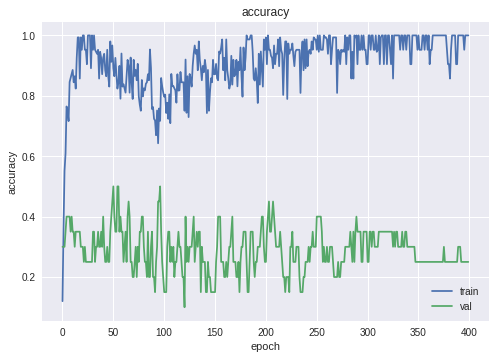

In [ ]:
plt.plot(train_accuracy, label='train')
plt.title('accuracy')
plt.ylabel('accuracy'); plt.xlabel('epoch')
plt.plot(val_acc, label='val')
plt.legend()
plt.show()

In [ ]:
#evaluasi model
test_set = Batik(X_test, y_test, PATH, transform=val_transform)

def predict(model, img, label):
    model.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = model(img)
        pred = torch.argmax(F.softmax(output, dim=1)).cpu().item()
    return pred

test_predict = []
true_label = []
for i in range(len(test_set)):
    img, label = test_set[i]
    prediction = predict(model, img, label)
    test_predict.append(prediction)
    true_label.append(label)

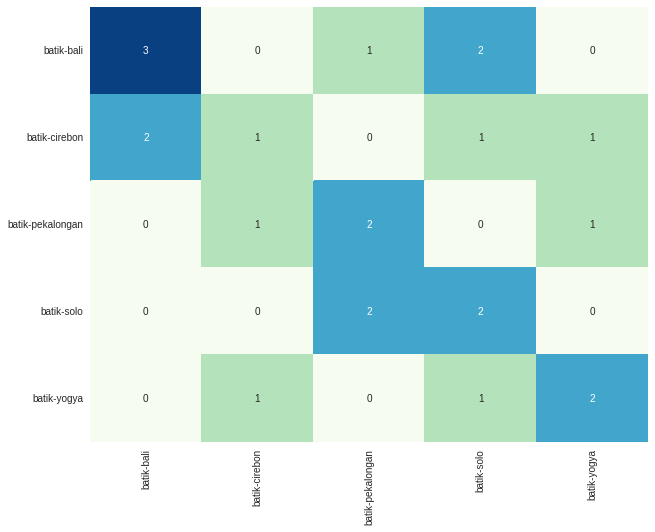

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(true_label, test_predict), annot=True, cmap='GnBu', cbar=False)
plt.xticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=90)
plt.yticks(ticks=np.arange(0.5, len(list(dicts.keys()))), labels = list(dicts.keys()), rotation=0)
plt.show()

In [ ]:
print(classification_report(true_label, test_predict))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.33      0.20      0.25         5
           2       0.40      0.50      0.44         4
           3       0.33      0.50      0.40         4
           4       0.50      0.50      0.50         4

    accuracy                           0.43        23
   macro avg       0.43      0.44      0.43        23
weighted avg       0.44      0.43      0.43        23



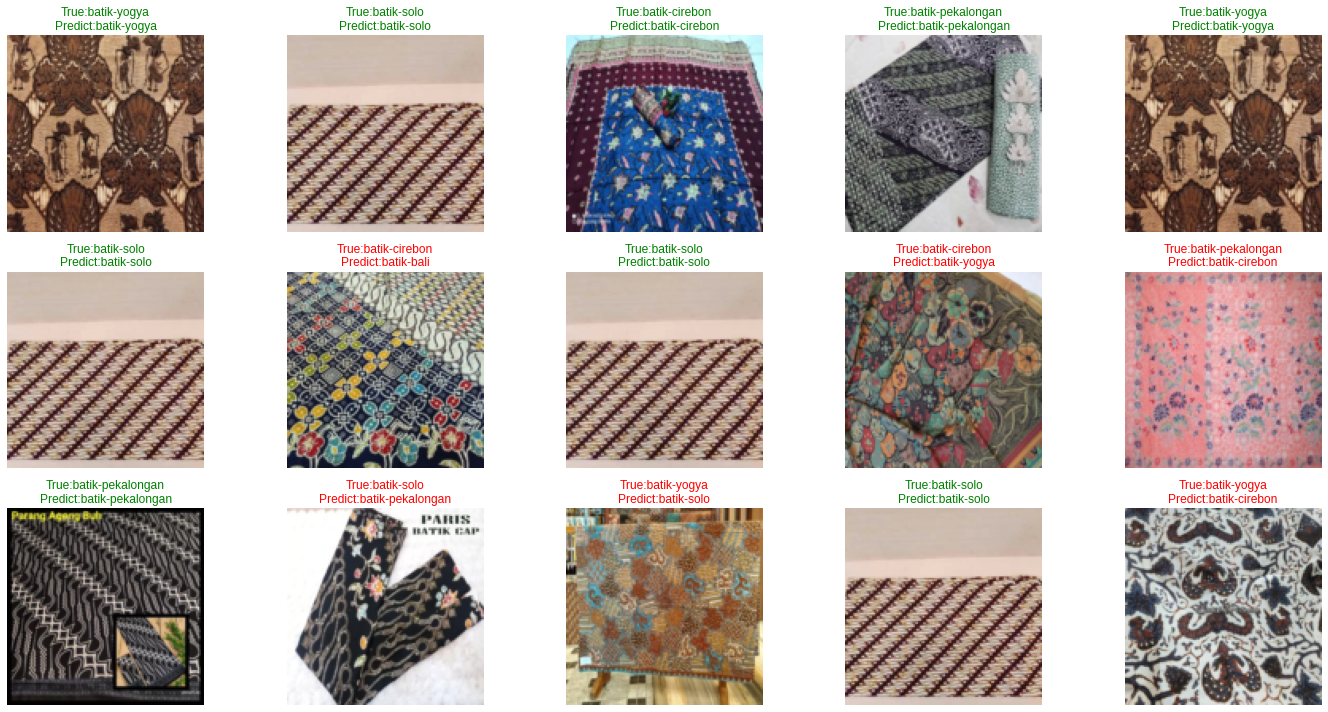

In [ ]:
#tampilkan batik random dari train klasifikasi menebak batik
random_selection = np.random.randint(0, len(test_predict), 15)

fig = plt.figure(figsize=(20, 10))

test_set = Batik (X_test, y_test, PATH, transform=T.Resize((124,124)))
for i, idx in enumerate(random_selection):
    image, label = test_set[idx]
    ax = fig.add_subplot(3, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image)
    ax.set_title('True:{}\nPredict:{}'.format(int_label[label], int_label[test_predict[idx]]),
                color=("green" if label == test_predict[idx] else 'red'), fontsize=12)

plt.tight_layout() 
plt.show()